<a href="https://colab.research.google.com/github/linusms/Hands-on/blob/main/chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tarfile ##tarfile은 파이썬 기본 내장 모듈인 듯
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/codingalzi/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "notebooks/datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
## 데이터 웹에서 불러오기

fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# 범주형 데이터의 분포 확인

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

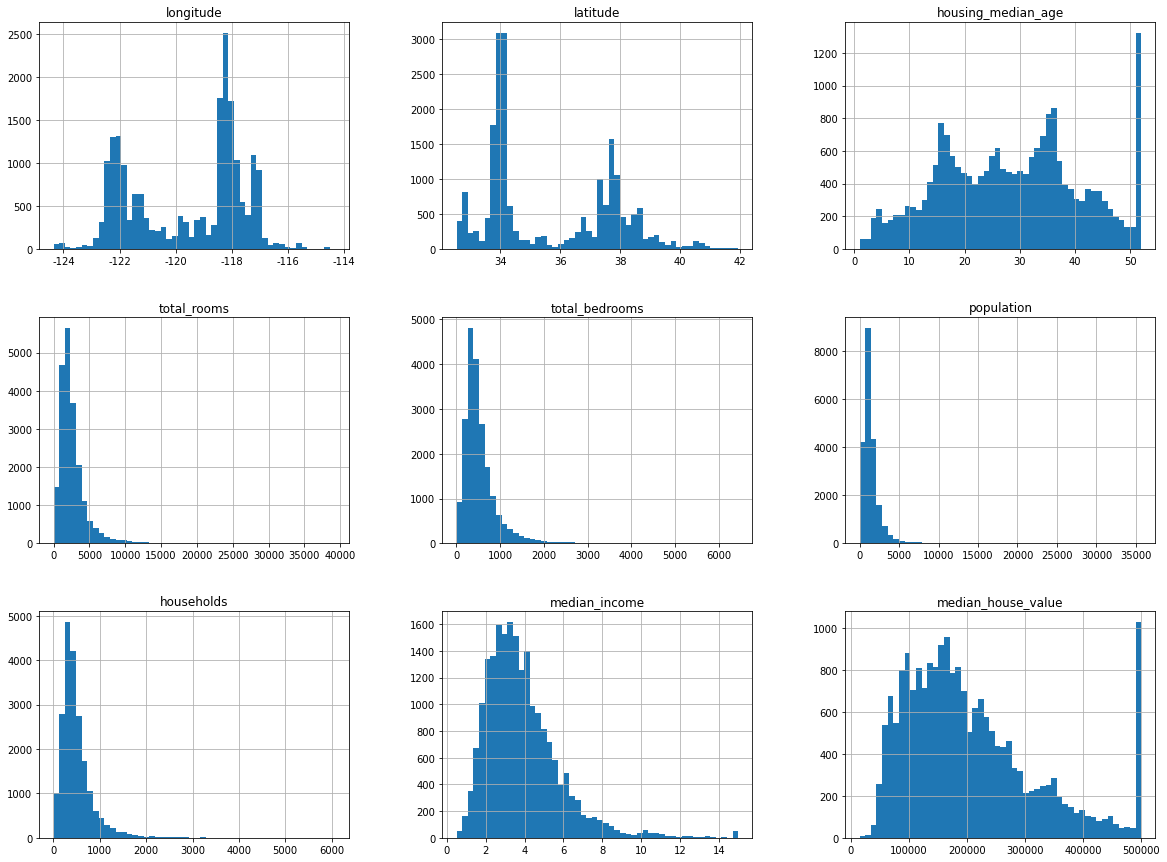

In [ ]:
# 전체 데이터의 형태 검토 - 숫자형 특성을 히스토그램으로 그려보기

import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
housing.hist(bins=50, figsize=(20,15))
plt.show()

# median_income의 x축을 보니 중간 소득이 달러가 아니고, 전처리된 데이터로 보임
# housing_median_age 와 median_house_value의 최댓값, 최솟값이 한정되어 있음. 레이블(예측의 답)으로 사용될 속성이므로
# 1) 한계값 밖의 구역에 대한 정확한 레이블을 구하거나 2) 한계값 밖의 구역을 훈련 세트에서 아예 제거해 버린다
# 특성간의 스케일이 - 부터 0~100, 10000~, 0~20 등 다양함. 특성 스케일링 필요
# 히스토그램의 꼬리가 두꺼움. 종 모양의 분포가 되어야 알고리즘에서 패턴 찾기 용이

In [ ]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data)) # data의 전체 정수 인덱스(0~len(data))를 무작위로 배치한 array 생성
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size] # 무작위 정수 인덱스 array의 앞에서부터 test_set_size만큼 선택. 이게 테스트 세트
    train_indices=shuffled_indices[test_set_size:] # 테스트 세트를 제외한 나머지가 훈련 세트
    return data.iloc[train_indices], data.iloc[test_indices]

# 주의. 여러번 실행하면 계속 다른 테스트 세트가 생성. 이는 전체 데이터셋을 보는 것과 마찬가지이므로 지양
# 1) 처음 실행한 테스트 세트를 변수에 저장 2) 난수 발생기의 초깃값 지정(random의 seed 지정)

In [ ]:
train_set, test_set=split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [ ]:
# 데이터셋 업데이트 시에도 안정적인 훈련/테스트 분할을 위한 함수
# 샘플의 식별자를 이용해 테스트 세트로 보낼지 결정
# 식별자가 없다면 행의 인덱스, 혹은 안정적인(오랫동안 바뀌지 않을) 특성을 사용해 식별자(id)를 만듬

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier))&0xffffffff<test_ratio*2**32

def split_train_test_by_id(data,test_ratio, id_column):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id=housing.reset_index()  # 'index'열이 추가됨. 
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
train_set2, test_set2=split_train_test_by_id(housing_with_id, 0.2, 'index')
print(len(train_set2))
print(len(test_set2))

16512
4128


In [ ]:
# 위도, 경도로 id 만들기 : 정밀도가 낮아 여러 구역의 id가 동일해짐
# 같은 id를 가진 여러 구역이 같은 테스트 세트/훈련 세트에 들어가므로 샘플링 편향이 일어남

housing_with_id['id']=housing['longitude']*1000+housing['latitude']
train_set3, test_set3=split_train_test_by_id(housing_with_id, 0.2, 'id')
print(len(train_set3))
print(len(test_set3))

16322
4318


In [ ]:
# 사이킷런에는 기본 함수로 train_test_split 함수 존재. 
# 1) random_state로 난수 초기값 설정 가능. 2) 행 개수가 같은 여러 개 데이터셋을 같은 인덱스 기반으로 나눌 수 있음

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set),'\n',train_set.head(),'\n')
print(len(test_set),'\n',test_set.head())


16512 
        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14196    -117.03     32.71                33.0       3126.0           627.0   
8267     -118.16     33.77                49.0       3382.0           787.0   
17445    -120.48     34.66                 4.0       1897.0           331.0   
14265    -117.11     32.69                36.0       1421.0           367.0   
2271     -119.80     36.78                43.0       2382.0           431.0   

       population  households  median_income  median_house_value  \
14196      2300.0       623.0         3.2596            103000.0   
8267       1314.0       756.0         3.8125            382100.0   
17445       915.0       336.0         4.1563            172600.0   
14265      1418.0       355.0         1.9425             93400.0   
2271        874.0       380.0         3.5542             96500.0   

      ocean_proximity  
14196      NEAR OCEAN  
8267       NEAR OCEAN  
17445      NEAR OCEAN  
14265      N

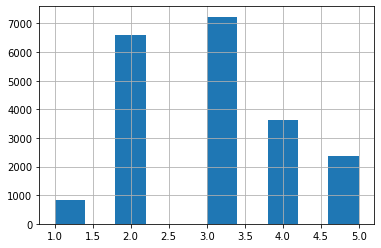

In [ ]:
# 앞서 한 순수한 무작위 샘플링 대신, 샘플링 편향을 막기 위한 계층적 샘플링
# 테스트 세트가 전체 데이터셋에 있는 여러 소득 카테고리(계층)을 잘 대표해야 함
# 1~5까지의 카테고리 값을 가지는 income_cat 열을 pd.cut() 함수를 이용해 만듬 

housing['income_cat']=pd.cut(housing['median_income'],bins=[0.,1.5,3.0,4.5,6.,np.inf], labels=[1,2,3,4,5])
housing['income_cat'].hist()

In [ ]:
# 계층 샘플링을 지원하는 StratfiedShuffleSplit 함수

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
# 테스트 세트에 있는 각 카테고리가 차지하는 비율 확인

strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
# 원본 데이터셋에 있는 각 카테고리가 차지하는 비율 확인
# 원본과 계층 샘플링으로 만든 테스트 세트(바로 위)의 카테고리 비율이 거의 같음

housing['income_cat'].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
# 일반 무작위 샘플링으로 만든 테스트 세트의 비율

train_set['income_cat']=pd.cut(train_set['median_income'],bins=[0.,1.5,3.0,4.5,6.,np.inf], labels=[1,2,3,4,5])
train_set['income_cat'].value_counts()/len(train_set)

3    0.348595
2    0.317466
4    0.178537
5    0.115673
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
# 계층 샘플링이 일반 무작위 샘플링보다 카테고리 비율 오차가 훨씬 적은 것을 볼 수 있다 

df1=(housing['income_cat'].value_counts()/len(housing)).to_frame()
df1.rename(columns={'income_cat':'original'}, inplace=True)
df2=(train_set['income_cat'].value_counts()/len(train_set)).to_frame()
df2.rename(columns={'income_cat':'random'}, inplace=True)
df3=(strat_train_set['income_cat'].value_counts()/len(strat_train_set)).to_frame()
df3.rename(columns={'income_cat':'strat'}, inplace=True)

df_all=pd.concat([df1,df2,df3], axis=1)
df_all['original-random']=df_all['original']-df_all['random']
df_all['original-strat']=df_all['original']-df_all['strat']
print(df_all)


   original    random     strat  original-random  original-strat
3  0.350581  0.348595  0.350594         0.001986       -0.000012
2  0.318847  0.317466  0.318859         0.001381       -0.000012
4  0.176308  0.178537  0.176296        -0.002229        0.000012
5  0.114438  0.115673  0.114462        -0.001235       -0.000024
1  0.039826  0.039729  0.039789         0.000097        0.000036


In [ ]:
# income_cat 특성 삭제. 

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

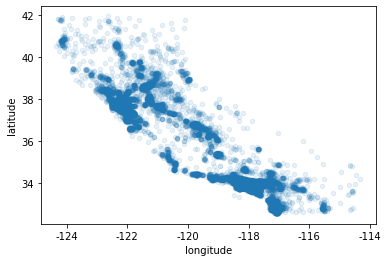

In [ ]:
# 데이터 분포 확인 위해 산점도 그리기
# 데이터의 복사본 만들고
# 산점도는 밀집 영역을 보기 위해 투명도(alpha)를 0.1로 설정

train_copy=strat_train_set.copy()
train_copy.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

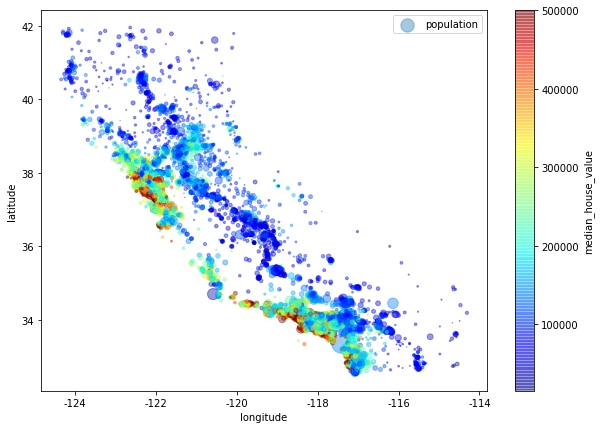

In [ ]:
# 위도,경도별 가구 분포에 주택 가격 중위값을 색으로 입히기
# c='색이 될 데이터가 있는 열 이름', cmap='색상표 preset', colorbar=True(색깔 표 표시)
# s=마커의 사이즈 결정. 데이터의 크기에 따라 다른 마커 사이즈 갖게 설정 가능

train_copy.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=train_copy['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
               sharex=False)
plt.show()

In [ ]:
# 데이터셋의 표준상관계수(Pearson의 상관계수)를 corr() 메소드를 사용해 구하기(결과값 행렬로 나옴)
# 주택 가격 중위값과 다른 특성 사이의 상관관계 확인
# 1에 가까우면 강한 양의 상관관계, -1이면 강한 음의 상관관계
# 0에 가까우면 선형적인 상관관계 없음

corr_matrix=train_copy.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

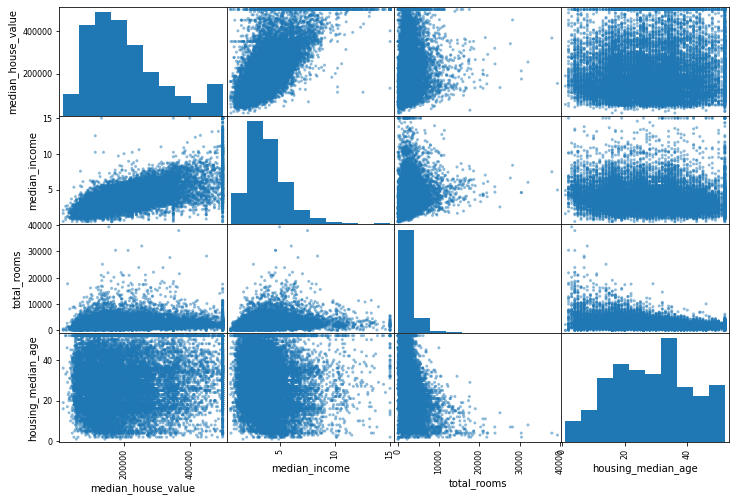

In [ ]:
# scatter_matrix 함수는 특성 간의 산점도를 각각 그려줌(n개의 특성시 n*n개의 산점도)
# median_house_value 와 median_income 사이의 상관관계가 강하고 따라서 가장 예측에 유용할 것 같음


from pandas.plotting import scatter_matrix

attributes=['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(train_copy[attributes],figsize=(12,8))
plt.show()

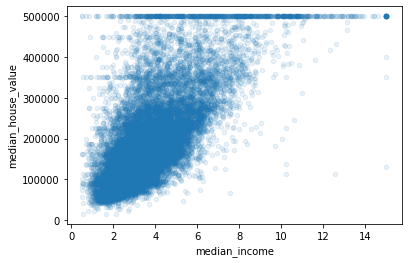

In [ ]:
# 가격 제한값이 명확히 보임. 500,000 , 450,000, 350,000, 280,000에도 있음
# 알고리즘에서 이러한 형태를 학습하지 않도록 해당 구역을 제거해야 함

train_copy.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)


In [ ]:
# 유용할 만한 특성들 조합, 새 특성 만들기
# 위치별 총 방 개수, 총 침실 개수보다는 가구당 방 개수, 가구당 침실 개수가 더 유용

train_copy['rooms_per_household']=train_copy['total_rooms']/train_copy['households']
train_copy['bedrooms_per_room']=train_copy['total_bedrooms']/train_copy['total_rooms']
train_copy['population_per_household']=train_copy['population']/train_copy['households']

# 새로 구한 특성과 상관계수 확인
# 새로 구한 특성들이 기존 전체 방 개수나 전체 침실 개수보다 더 상관관계 높음

corr_matrix=train_copy.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [ ]:
# 데이터 전처리 시작
# 예측 변수와 타겟값에 같은 변형을 적용하지 않기 위해 
# 예측 변수들(레이블 제외한 나머지)과 레이블(답, 예측하고자 하는 값) 분리

housing=strat_train_set.drop('median_house_value', axis=1)
housing_labels=strat_train_set['median_house_value'].copy()

In [ ]:
## 실행하지 말 것

# 데이터 결측치 제거 방법들

housing.dropna(subset=['total_bedrooms']) 
housing.drop('total_bedrooms', axis=1) # 결측치 있는 특성 삭제
median=housing['total_bedrooms'].median() # 결측치 있는 열의 중위값. 후에 자주 쓰이므로 변수에 저장
housing['total_bedrooms'].fillna(median, inplace=True) # 결측치를 중위값으로 채움



In [ ]:
# 결측치를 쉽게 다루도록 해주는 SimpleImputer 함수

from sklearn.impute import SimpleImputer

# 각 특성당 결측치에 중위값을 계산해 넣어주는 imputer 객체 생성
# 실제로는 total_bedrooms 특성에만 결측치 있지만, 후에 들어올 새 데이터에 어떤 특성이 결측값을 가질지 모르므로
# 각 특성당 중위값을 계산하고 저장하는 imputer 객체 생성이 바람직함
imputer=SimpleImputer(strategy='median')


# 중위값은 수치형 특성에서만 계산될 수 있으므로 텍스트 특성 제거
# 이후 imputer 객체에 fit() 메서드를 이용해 특성당 중위값 계산
housing_num=housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [ ]:
# 학습된 imputer 객체를 사용해 훈련 세트에서 누락된 값을 학습한 중간값으로 바꾸기

x=imputer.transform(housing_num)
# 변환기에서 반환된 값은 배열(array)이므로 데이터프레임으로 변환
housing_tr=pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [ ]:
# 범주형 텍스트 특성만 분리 - 데이터프레임 형태로 추출
housing_cat=housing[['ocean_proximity']]
print(housing_cat.head())

# 범주형 텍스트 -> 숫자 변환 위해 OrdinalEncoder 클래스 사용

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN


array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
# 문제점 : 숫자상으로 가까이 있는 두 값이 실제로는 비슷한 특성이 아닌 경우 
# <1H OCEAN과 INLAND 보다는 NEAR OCEAN이 더 가까운 의미의 특성값

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
# 위와 같은 문제점 해결 : One-Hot Encoding
# 카테고리별로 이진 특성 만드는 클래스
# 결과값으로 희소 행렬 반환
# 희소 행렬은 0이 아닌 원소의 위치만 저장하는 행렬

from sklearn.preprocessing import OneHotEncoder
cat_encoder=OneHotEncoder()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
# 앞서 진행한 bedrooms_per_room, popluation_per_household 열을 추가해주는 추정기 만들기
# BaseEstimator, TransformerMixin 클래스 상속. -> get_params(), set_params(), fit_transform() 그대로 이용
# 이 추정기는 add_bedrooms_per_room라는 매개변수 하나만을 갖고, 
# add_bedrooms_per_room이라는 매개변수값이 False라면 rooms_per_household, population_per_household 열만 추가
# True라면 bedrooms_per_room 열도 추가

from sklearn.base import BaseEstimator, TransformerMixin

# 필요한 열 인덱스 동적으로 구하기 by get_loc()
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] 


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없으며, 키워드 인자 활용함.
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않음
    def transform(self, X):
        #배열 간의 사칙연산. 특정 열의 모든 행을 각각 나누기
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
    
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            
            # np.c_ 두 배열을 열을 축으로 해서 이어붙이기
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) # 연습 용도로 방당 침실수를 추가하지 않음

# bedrooms_per_room 열만 포함되지 않은 새로운 데이터프레임 housing_extra_attribs
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [ ]:


# 변환 파이프라인의 예시
# 파이프라인이란 한 데이터의 출력이 다음 단계의 입력으로 이어지는 구조
# sklearn에서는 여러개의 추정기/변환기가 연결된 형태를 말함
# 입력 방식은 Pipeline(['추정기 이름(사용자 설정)', 추정기 이름()])
# 마지막에는 변환기/추정기 모두 사용가능, 이외는 모두 변환기(fit_transform() 메서드 포함해야 함)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()), # 마지막에도 ,를 붙이는게 특이함
])



In [ ]:

# 각 열마다 다른 변환기 적용하는 파이프라인 ColumnTransformer

from sklearn.compose import ColumnTransformer

num_attribs=list(housing_num)
cat_attribs=['ocean_proximity']

full_pipeline=ColumnTransformer([
    ('num', num_pipeline, num_attribs), # Pipeline과 비슷하지만 마지막에 적용할 열 이름이 들어감(리스트 형식으로 입력)
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared=full_pipeline.fit_transform(housing)

In [ ]:
# 선형회귀 모델에서 주어진 데이터셋(housing_prepared)에 대한 적절한 파라미터를 찾아내는 fit() 메소드
# fit() 메소드는 입력 데이터셋과 결과값(레이블) 두 개를 매개변수로 가진다


from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
# housing은 계층 샘플링으로 뽑아낸 훈련 세트에서 답인 label을 떼어놓은 데이터셋
# 레이블이 제거된 훈련 세트와 해당 훈련 세트의 레이블에서 5개씩을 뽑아 간단히 예측  
# 결과에서 보이듯이, 그다지 정확한 예측은 아님

some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepared=full_pipeline.transform(some_data)
print('예측:', lin_reg.predict(some_data_prepared))
print('레이블:', list(some_labels))

예측: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [ ]:
# rmse : root mean square error. 오차 확인
# 이 뜻은 120,000 ~ 265,000 사이의 값을 가지는 주택 가격 중위값 특성에서 
# 예측값이 실제 데이터와 68,628 만큼의 차이가 난다는 뜻. 좋지 않은 예측
# 과소적합 : 1) 좋은 예측을 만들기에 데이터가 충분히 많지 않거나 2) 모델이 충분히 강력하지 않다.
# 해결책 : 1) 더 좋은 특성 입력 2) 강력한 모델 선택 3) 모델의 규제 감소(규제 사용시)

from sklearn.metrics import mean_squared_error 
housing_predictions=lin_reg.predict(housing_prepared)
lin_mse=mean_squared_error(housing_labels, housing_predictions)
lin_rmse=np.sqrt(lin_mse)
print(lin_rmse)

68627.87390018745


In [ ]:
# 좀 더 복잡한 모델 : DEcisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

tree_reg=DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [ ]:
housing_predictions=tree_reg.predict(housing_prepared)
tree_mse=mean_squared_error(housing_labels, housing_predictions)
tree_rmse=np.sqrt(tree_mse)
tree_rmse

0.0

In [ ]:
# 교차 검증(더 작은 훈련 세트와 검증 세트 만들어 훈련)
# 사이킷런의 k-겹 교차 검증 기능 사용
# cross_val_score(모델명, 훈련 데이터(레이블 제거됨), 훈련 데이터 레이블, 
# scoring=neg_mean_squared_error(비용 함수가 아니라 효용 함수), cv=폴드 개수(훈련 세트의 서브셋))

from sklearn.model_selection import cross_val_score
scores=cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores=np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print('점수:', scores)
    print('평균:', scores.mean())
    print('표준편차:', scores.std())

# 결정 트리 모델의 점수
    
display_scores(tree_rmse_scores)

점수: [73283.63334845 71017.67378444 68982.86579928 70253.70020956
 71608.88210214 77413.82620931 72565.33317448 73918.96104179
 67710.36736348 70801.14949373]
평균: 71755.6392526669
표준편차: 2597.5163246314473


In [ ]:
# 선형 회귀 모델의 점수
# 결정 트리 모델이 더 점수가 좋지 않음을 볼 수 있음(낮을 수록 좋음)

lin_scores=cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores=np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균: 69104.07998247063
표준편차: 2880.3282098180634


In [ ]:
# 랜덤포레스트 모델 성능 평가. 앞선 두 모델보다는 좋다 
# 최종 모델로 선정하기 전(즉, 하이퍼파라미터 튜닝 전) 다양한 모델(svm, 신경망 등)을 시도해보면 좋음

from sklearn.ensemble import RandomForestRegressor

forest_reg=RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_mse=mean_squared_error(housing_labels, housing_predictions)
forest_rmse=np.sqrt(forest_mse)
print(forest_rmse)
forest_scores=cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores=np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

0.0
점수: [51306.97213164 49053.94080573 46688.41677334 52094.66475846
 47306.05927174 51746.01039822 52337.43953908 49615.82565361
 48335.15107871 53636.25935291]
평균: 50212.07397634171
표준편차: 2223.034881701656


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 첫째 경우: 총 12(=3×4)개의 하이퍼파라미터 조합 시도
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # 둘째 경우: bootstrap은 False로 하고 총 6(=2×3)개의 조합 시도
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 5-겹 교차 검증 시도. 따라서 총 (12+6)*5=90번의 훈련 진행
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
# 집어넣은 최대값이 파라미터로 설정되었으므로 더 큰 값 넣어볼 생각

grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
# 최적의 파라미터를 가지는 최상의 랜덤 포레스트 회귀 모델은
# best_estimator_ 속성에 저장됨

grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [ ]:
# 각 18개 조합의 하이퍼파리미터들에 대한 평가 점수는 cv_result_ 속성에 저장됨

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1